<a href="https://colab.research.google.com/github/Nancy-Shi/Individual_Infection_Network/blob/main/Network_Matrix_to_Visualization_v3_Cleaned_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this part of the project, we create a tool to achieve the following:
1. Our input is an N by N matrix representing a social network with N nodes with 1 or 0 representing the presence or absence of edges.
2. We then construct a graph from the given matrix.
3. Based on the network, we apply the equations for individual infection risk, derive the corresponding equations, and compute a table of probability with infection starting at different nodes.
4. Finally, we take the average infection probability of each node, excluding the case when it is the seed.
5. Depending on the average infection probabilty, we color the network graph with a heatmap color scheme, such that red is the highest infection risk and blue/purple is the lowest infection risk.
6. Our output include: a probability table, a table including all the average infection probability, and a heatmap network for individual infection probability/risk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import numpy as np
import pandas as pd
import os
import sympy as sp

In [ ]:
# Function to generate a random N by N adjacency matrix representing a network without self-loop give number of nodes N
def generate_random_network(N, p=0.3):
    adj_matrix = [[0]*N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            if i != j:
                adj_matrix[i][j] = 1 if random.random() < p else 0
    return adj_matrix

In [ ]:
# Function to generate a network from an N by N adjacency matrix.
def generate_network(adj_matrix):
    G = nx.Graph()
    N = len(adj_matrix)
    for i in range(N):
        for j in range(i+1, N):   # avoid duplicates and self-loops
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)
    return G

In [ ]:
def preprocess_neighbors(G):
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    neighbors_idx = []

    for v in nodes:
        neighs = list(G.neighbors(v))
        neighbors_idx.append(np.array([node_index[u] for u in neighs], dtype=int))

    return nodes, node_index, neighbors_idx

In [ ]:
def fixed_point_solver_pre(neighbors_idx, seed_index, p_val, tol=1e-6, max_iter=5000, relax=0.3):
    n = len(neighbors_idx)
    sigma = np.zeros(n)

    for _ in range(max_iter):
        sigma_new = sigma.copy()

        for i in range(n):
            if i == seed_index:
                sigma_new[i] = 1.0
            else:
                neigh = neighbors_idx[i]
                if neigh.size == 0:
                    sigma_new[i] = 0.0
                else:
                    prod_term = np.prod((1.0 - p_val) * sigma[neigh])
                    sigma_new[i] = 1.0 - prod_term

        sigma_updated = (1 - relax) * sigma + relax * sigma_new
        if np.max(np.abs(sigma_updated - sigma)) < tol:
            return sigma_updated

        sigma = sigma_updated

    return sigma

In [ ]:
def fixed_point_solver(G, p_val, seed_nodes, tol=1e-9, max_iter=50000):
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    n = len(nodes)

    neighbors_idx = []
    for i_node in nodes:
        neighs = list(G.predecessors(i_node)) if G.is_directed() else list(G.neighbors(i_node))
        neighbors_idx.append(np.array([node_index[j] for j in neighs], dtype=int))

    # Initialize sigma values
    sigma_vals = np.zeros(n)
    for seed in seed_nodes:
        sigma_vals[node_index[seed]] = 1.0

    # Iteration
    for it in range(max_iter):
        sigma_new = sigma_vals.copy()

        for i, neigh_idx in enumerate(neighbors_idx):
            if nodes[i] in seed_nodes:
                sigma_new[i] = 1.0
            elif neigh_idx.size == 0:
                sigma_new[i] = 0.0
            else:
                # vectorized product over neighbors
                prod_term = np.prod(1.0 - p_val) * sigma_vals[neigh_idx]
                sigma_new[i] = 1.0 - prod_term

        # Damped update
        relax = 0.3 # pure fixed-point iteration can oscillate or converge very slowly, relaxation is a simple trick and can usually go between 0.3 to 0.7
        sigma_updated = (1.0 - relax) * sigma_vals + relax * sigma_new

        # Optional clipping for safety
        np.clip(sigma_updated, 0.0, 1.0, out=sigma_updated)

        # Convergence check
        if np.max(np.abs(sigma_new - sigma_vals)) < tol:
            #print(f"Converged in {it} iterations.")
            return sigma_new.tolist()

        sigma_vals = sigma_new

    print("⚠️ Did not converge within max_iter.")
    return sigma_vals.tolist()

In [ ]:
from joblib import Parallel, delayed

def compute_attack_matrix(G, p_val, n_jobs=-1):
    nodes, node_index, neighbors_idx = preprocess_neighbors(G)
    n = len(nodes)

    sigmas = Parallel(n_jobs=n_jobs)(
        delayed(fixed_point_solver_pre)(neighbors_idx, seed_index=node_index[s], p_val=p_val)
        for s in nodes
    )

    mat = np.array(sigmas).T

    return nodes, mat


def save_attack_csv(nodes, mat, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame(
        mat,
        index=[f"sigma_{i}" for i in nodes],
        columns=[f"Seed {i}" for i in nodes]
    )
    path = os.path.join(outdir, f"individual_v3_p{p_val:.3f}.csv")
    df.to_csv(path, float_format="%.6f")
    return path, df

In [ ]:
# Function to compute the average infection rate by taking the average of the matrix for each row, excluding the 1 value (seed node case)
def compute_average_attack(nodes, mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)   # remove self-seed values
    return np.nanmean(mat_no_diag, axis=1)

def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)

    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })

    path = os.path.join(outdir, f"average_v3_p{p_val:.3f}.csv")
    df.to_csv(path, index=False, float_format="%.6f")

    return path, df


In [ ]:
# Function to visualize the network based on the node index, color the nodes based on a heatmap scale using their average attack rate
def visualize_attack_network_scirep(
    G,
    nodes,
    avg_attack,
    cmap_name="jet",
    out_path="/content/drive/My Drive/Individual_Attack_Rate/individual_attack_network_v3.pdf"
):
    nodes = list(nodes)
    avg_attack = np.asarray(avg_attack, dtype=float)
    attack_dict = {node: avg_attack[i] for i, node in enumerate(nodes)}
    pos = nx.spring_layout(G, seed=42, k=0.25, iterations=300)
    node_colors = [attack_dict[n] for n in G.nodes()]
    vmin = float(np.nanmin(avg_attack))
    vmax = float(np.nanmax(avg_attack))
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_facecolor("white")
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.8, width=1.0, edge_color="gray")
    nodes_draw = nx.draw_networkx_nodes(
        G,
        pos,
        ax=ax,
        node_color=node_colors,
        cmap=plt.get_cmap(cmap_name),
        node_size=80,
        linewidths=0.4,
        edgecolors="black",
        vmin=vmin,
        vmax=vmax
    )
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=4.5)
    cbar = fig.colorbar(nodes_draw, ax=ax, orientation="horizontal", fraction=0.05, pad=0.08)
    cbar.set_label("Average individual infection probability", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    plt.show()


In [ ]:
N = 1000
target_k = 10
q = target_k / (N - 1)
adj_matrix = generate_random_network(N, q)
p = 0.1
with open("/content/drive/My Drive/Individual_Attack_Rate/adj_matrix_1000_v3.pkl", "wb") as f:
    pickle.dump(adj_matrix, f)
G = generate_network(adj_matrix)
with open("/content/drive/My Drive/Individual_Attack_Rate/sample_network_1000_v3.pkl", "wb") as f:
    pickle.dump(G, f)
nodes, mat = compute_attack_matrix(G, p)
path, df = save_attack_csv(nodes, mat, p)
avg_attack = compute_average_attack(nodes, mat)
path2,df2 = save_average_attack_csv(nodes, avg_attack, p)
#visualize_attack_network_scirep(G, nodes, avg_attack)

In [ ]:
with open("/content/drive/My Drive/Individual_Attack_Rate/adj_matrix_1000_v3.pkl", "rb") as f:
    adj_matrix = pickle.load(f)
with open("/content/drive/My Drive/Individual_Attack_Rate/sample_network_1000_v3.pkl", "rb") as f:
    G_loaded = pickle.load(f)

In [ ]:
import pandas as pd
import os

def save_graph_neighbor_csv(G, filename="graph_neighbors_v3.csv"):
    outdir = "/content/drive/My Drive/Individual_Attack_Rate"
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)

    nodes = sorted(G.nodes())
    index_map = {v: i for i, v in enumerate(nodes)}

    data = []
    for v in nodes:
        neigh_indices = [index_map[u] for u in G.neighbors(v)]
        neigh_str = ",".join(str(n) for n in neigh_indices)
        degree = len(neigh_indices)
        data.append([index_map[v], neigh_str, degree])

    df = pd.DataFrame(data, columns=["node", "neighbors", "degree"])
    df.to_csv(path, index=False)

    return path, df

In [ ]:
path3, df3 = save_graph_neighbor_csv(G, "G_neighbors_v3.csv")
print("Saved to:", path3)

Saved to: /content/drive/My Drive/Individual_Attack_Rate/G_neighbors_v3.csv


In [ ]:
import pandas as pd
import os

def rank_nodes_by_attack(csv_path, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    # read the csv
    df = pd.read_csv(csv_path)

    # sort by highest attack rate
    df_ranked = df.sort_values(by="AverageAttackRate", ascending=False).reset_index(drop=True)

    # add rank column (1 = highest infection probability)
    df_ranked["Rank"] = df_ranked.index + 1

    # save new ranked csv
    os.makedirs(outdir, exist_ok=True)
    out_path = os.path.join(outdir, "ranked_1000_" + os.path.basename(csv_path))
    df_ranked.to_csv(out_path, index=False, float_format="%.6f")

    print("\nRanked results:\n")
    print(df_ranked.head())

    return out_path, df_ranked

In [ ]:
csv_path = "/content/drive/My Drive/Individual_Attack_Rate/average_v3_p0.100.csv"

out_path, df_ranked = rank_nodes_by_attack(csv_path)
print("Saved ranked file to:", out_path)


Ranked results:

   Node  AverageAttackRate  Rank
0   839           0.999072     1
1   302           0.998776     2
2    89           0.997862     3
3    10           0.997579     4
4   806           0.996848     5
Saved ranked file to: /content/drive/My Drive/Individual_Attack_Rate/ranked_1000_average_v3_p0.100.csv


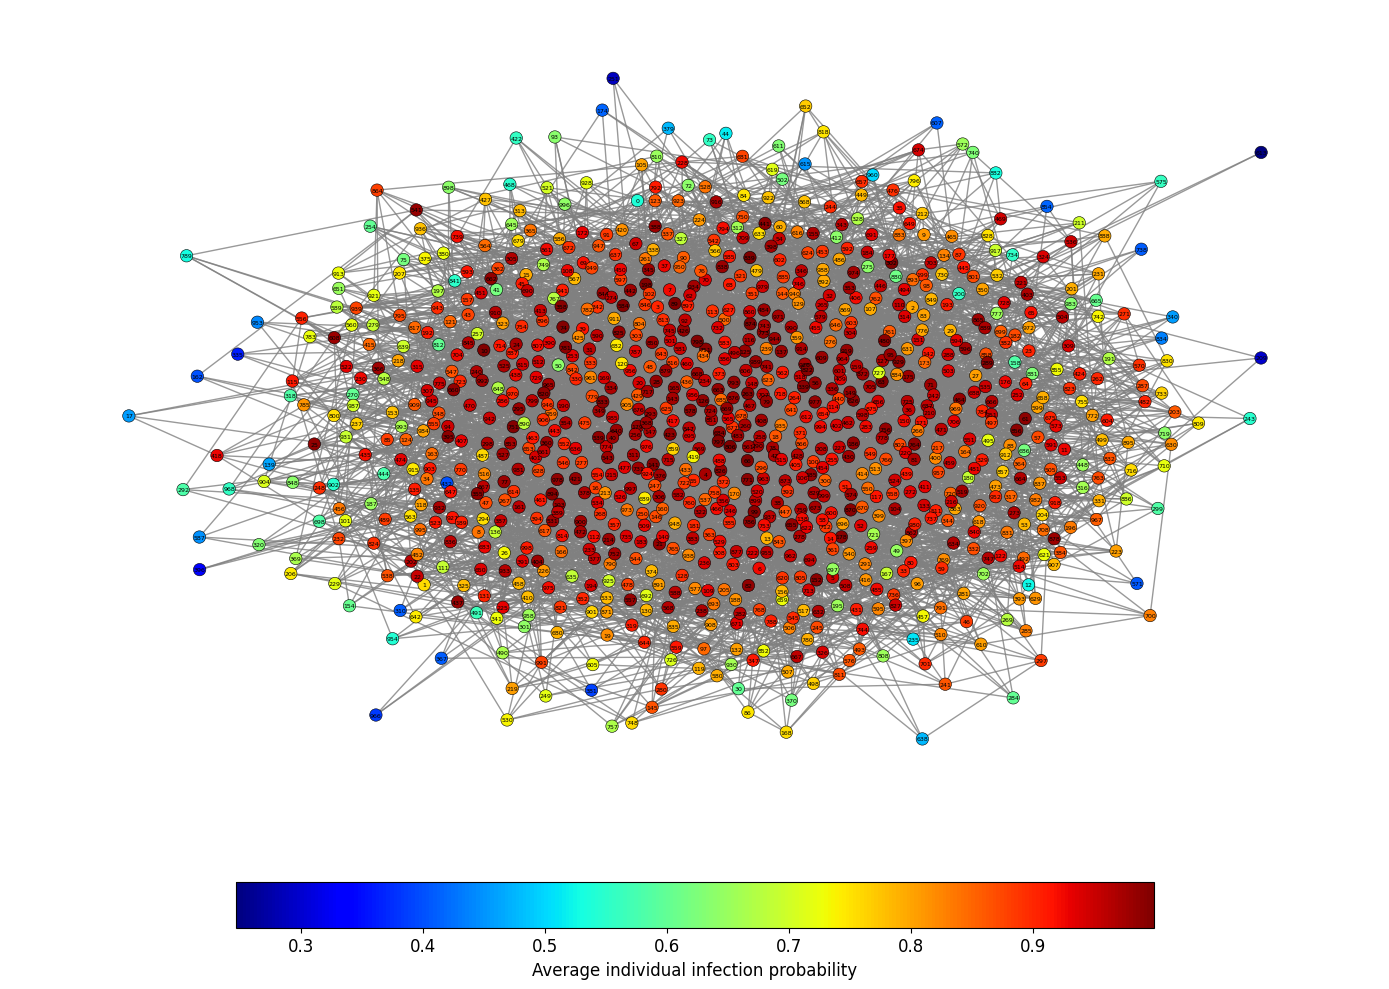

In [ ]:
visualize_attack_network_scirep(G, nodes, avg_attack)

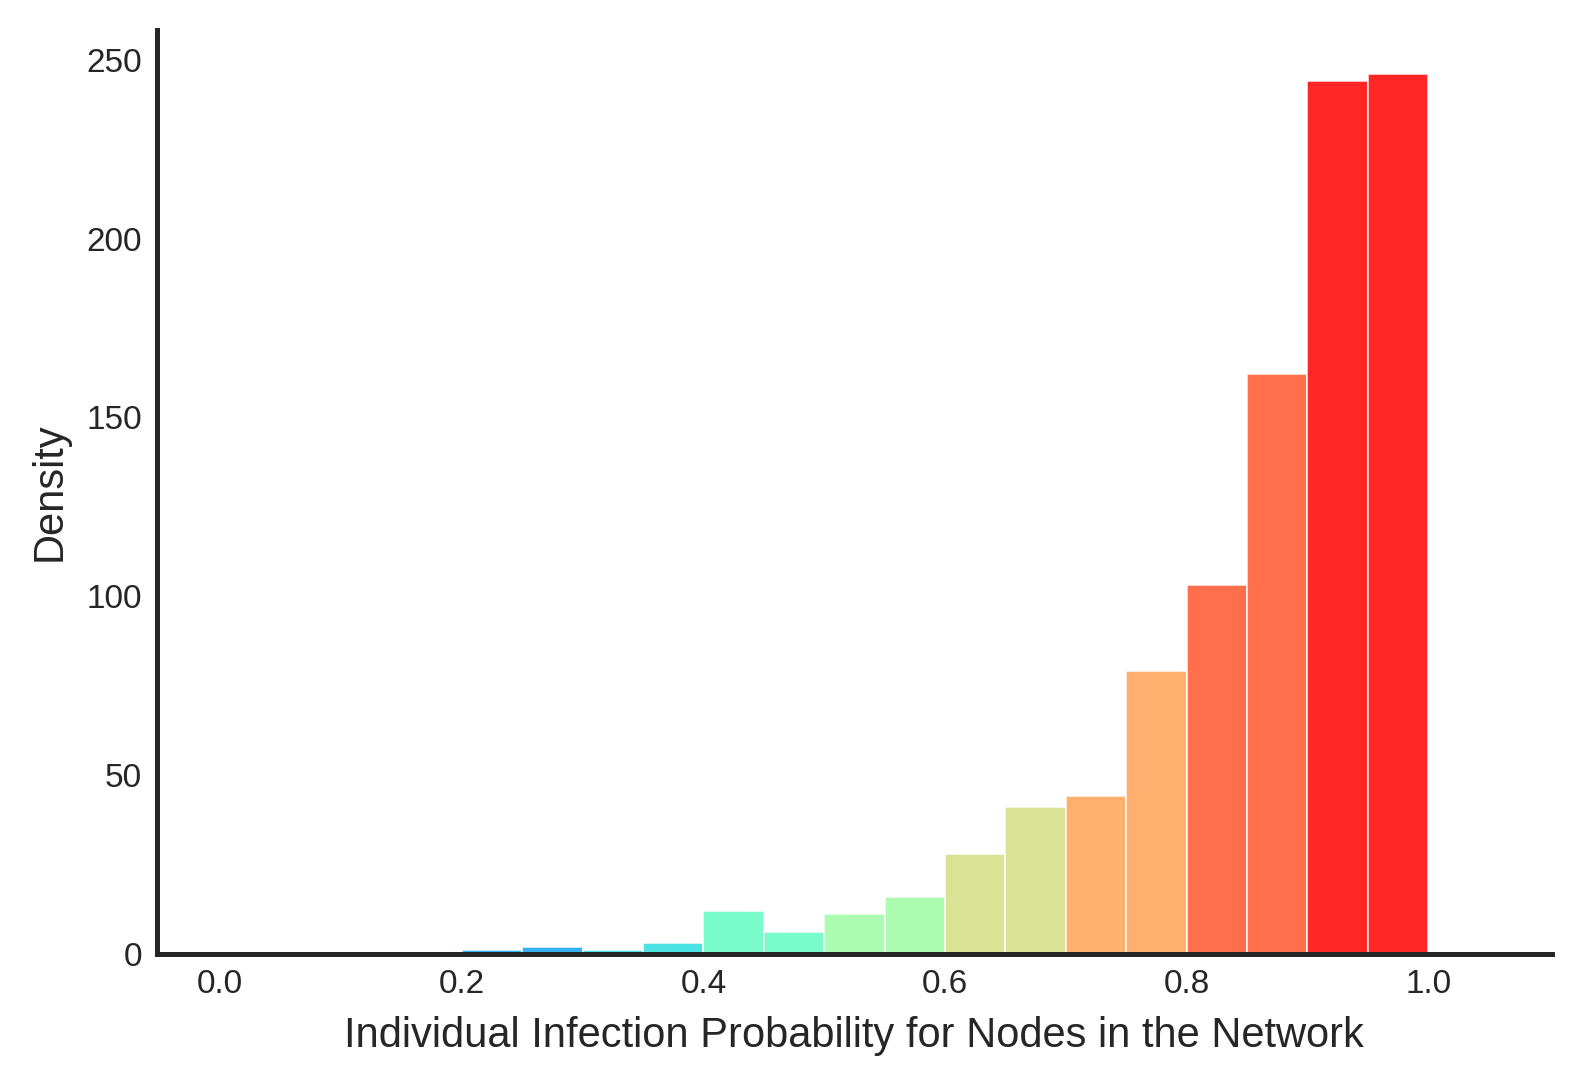

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ranked_path = "/content/drive/My Drive/Individual_Attack_Rate/ranked_1000_average_v3_p0.100.csv"
df_ranked = pd.read_csv(ranked_path)

vals = df_ranked["AverageAttackRate"].values
vals = vals[~np.isnan(vals)]

plt.style.use("seaborn-v0_8-white")

main_bins = np.arange(0, 1.1, 0.1)
hist_bins = np.arange(0, 1.05 + 0.001, 0.05)   # bin width = 0.05

colors = plt.cm.rainbow(np.linspace(0, 1, len(main_bins)-1))

plt.figure(figsize=(6, 4), dpi=300)

for i in range(len(main_bins)-1):
    lo, hi = main_bins[i], main_bins[i+1]
    mask = (vals >= lo) & (vals < hi)
    plt.hist(
        vals[mask],
        bins=hist_bins,
        alpha=0.85,
        color=colors[i],
        edgecolor="white",
        linewidth=0.4
    )

plt.xlabel("Individual Infection Probability for Nodes in the Network", fontsize=10)
plt.ylabel("Density", fontsize=10)
#plt.title("Distribution of Individual Infection Probability", fontsize=15)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

plt.savefig("/content/drive/My Drive/Individual_Attack_Rate/histogram_1000_v3.pdf", bbox_inches="tight")
plt.show()